In [1]:
%%time
import sys, os
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/Cerebellar_Open_Closed_Loops'
path_data = f'/mnt/User_Data/UserData/eliasmfs/Cerebellar_Open_Closed_Loops/SlowData/'
path_code = f'{path_gen}'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
from tqdm import tqdm
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 200
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['positive', 'negative']

                
seed_number_range = ['closed_open_loops_diff_tau']                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 1
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
sims = ["eye_blink","eye_blink_open","pulse","pulse_open"]
 
        
f0_range = [sims[0],sims[1],sims[2],sims[3]]

parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02
                    "unfiltered": False, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "simulations": sims,
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}


Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = f0_range[0]

zebrin_col = dict(positive='b',negative='r')
linstyle = dict(no_Plasticity='-',after_Plasticity='--')

WARNING    <timed exec>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 29.6 s, sys: 9.42 s, total: 39 s
Wall time: 46 s


## Figure 2 - B

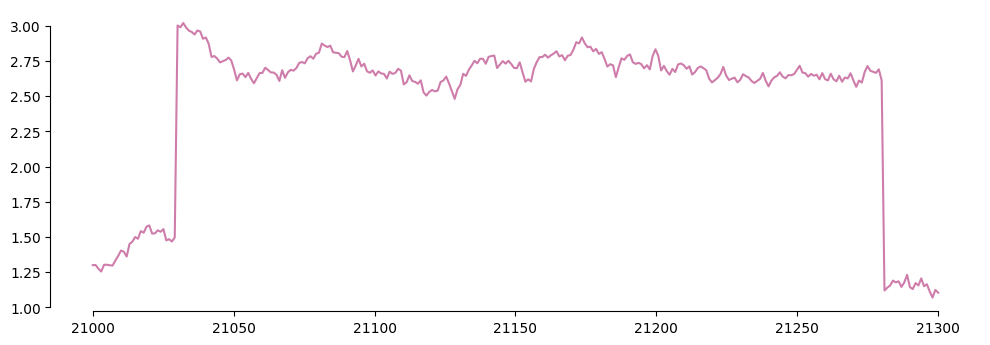

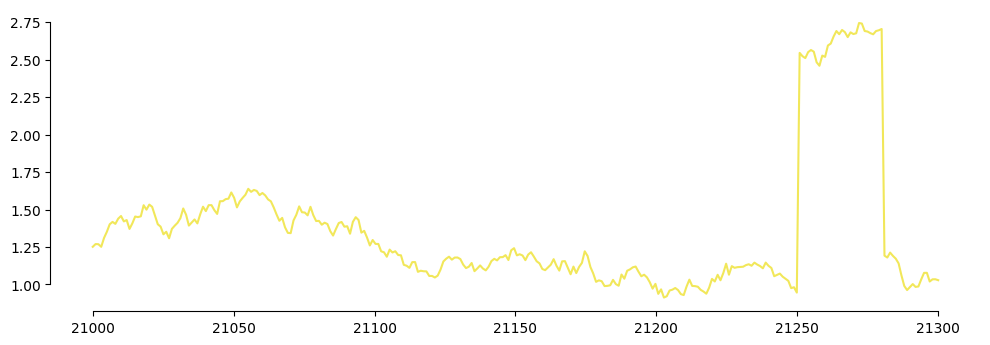

In [2]:
color_arr = ['#cd79a8f8','#f0e442df']

start = int(21000)
end = int(21300)
x_ax = linspace(int(start),int(end),int(end-start))
Noise_I = output_load_run('Noise',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['I']

ii = 0
for N_Noise in [3,4]:#range(N_Cells_PF):
    fig = plt.figure(figsize=(12, 4),dpi=100)
    y_ax = Noise_I
    plot(x_ax,y_ax[N_Noise][start:end]/nA*amp,color_arr[ii],label=f'PF {N_Noise}')
    ii+=1
    sns.despine(trim=True)
    plt.show()

## Figure 2 - D

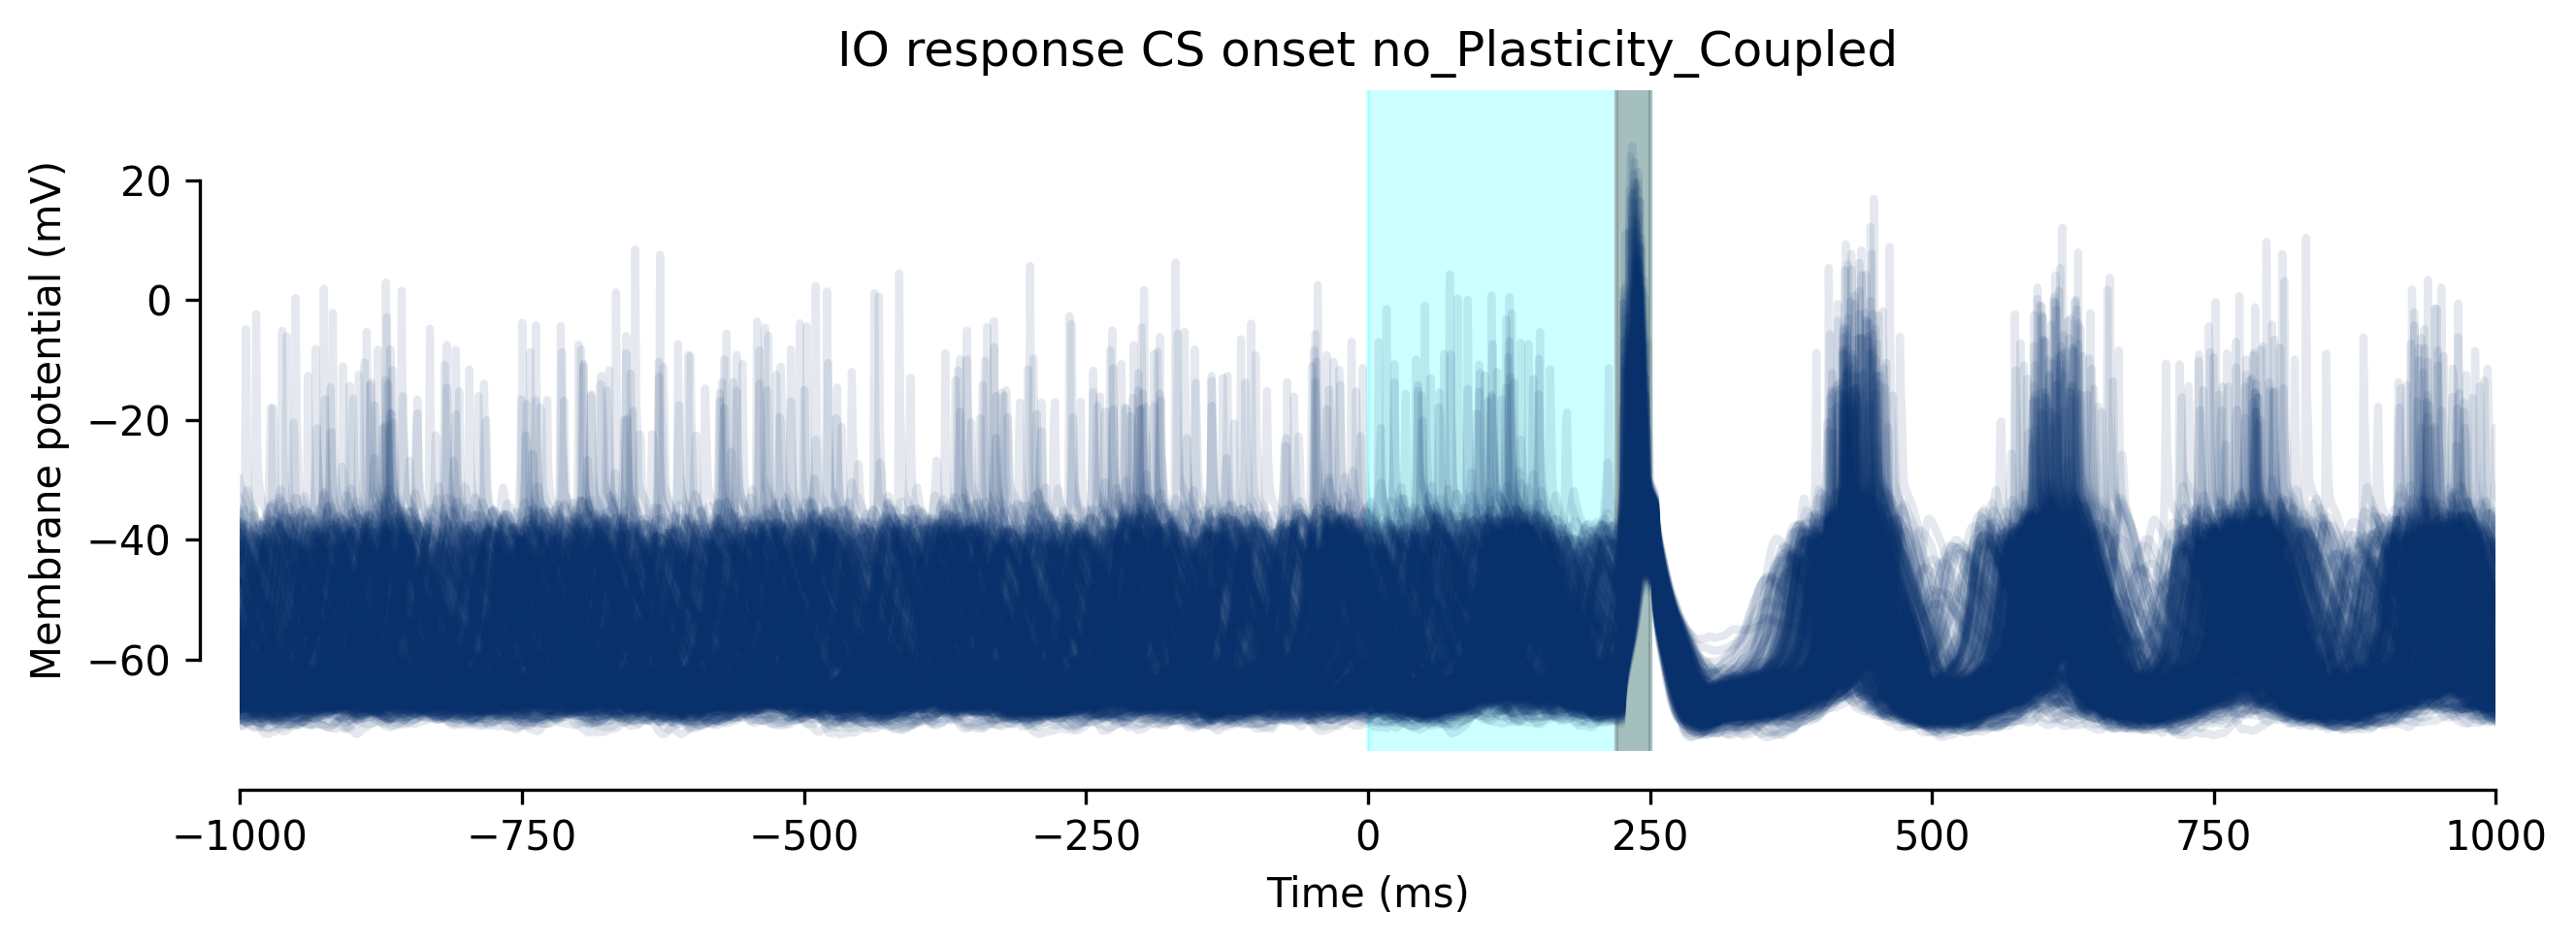

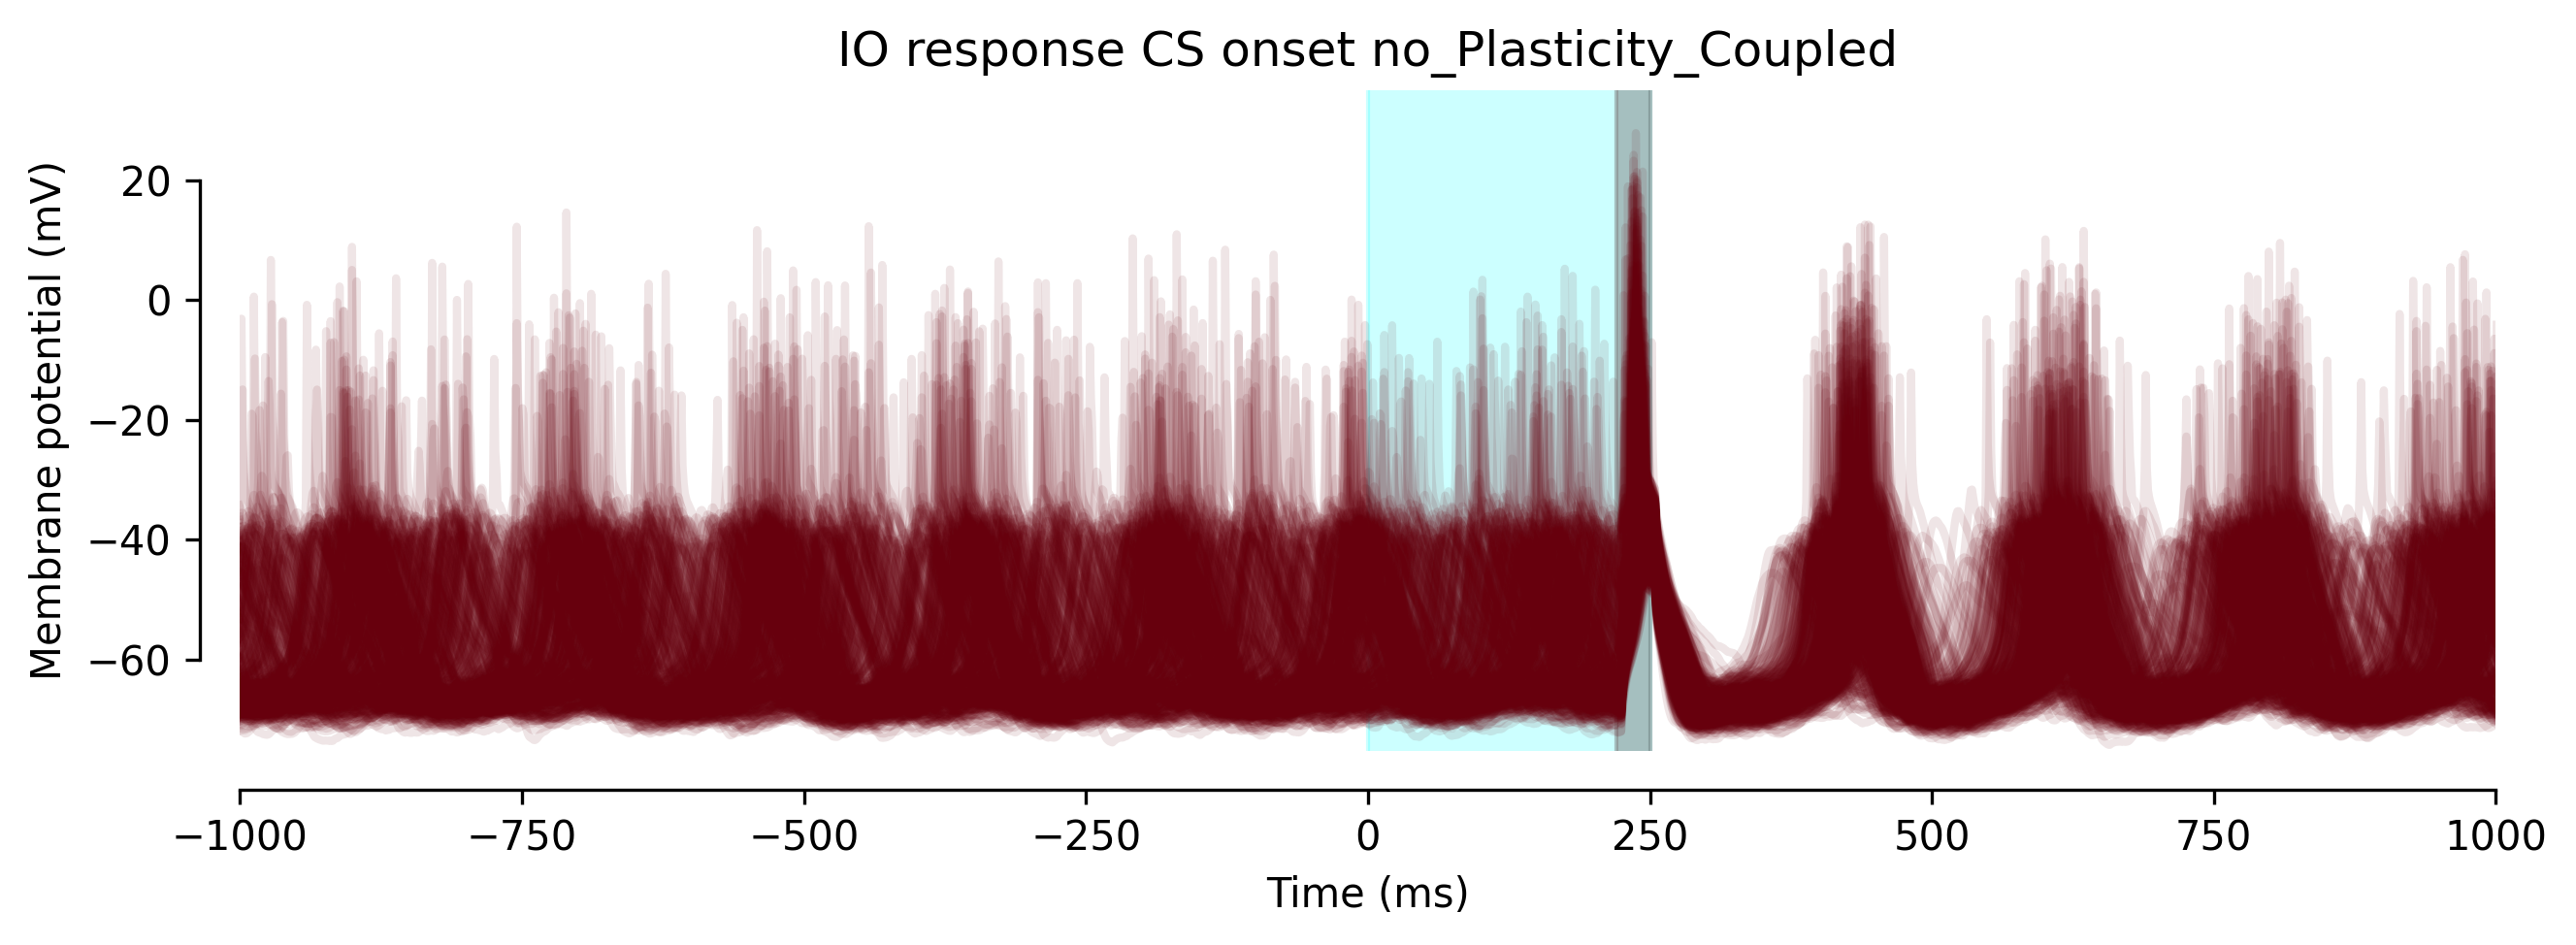

CPU times: user 3.28 s, sys: 948 ms, total: 4.23 s
Wall time: 10.6 s


In [3]:
%%time
seed_number = seed_number_range[0]
Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
iti_arr = Noise_sim[f'iti_arr_{f0}']
iti_arr = iti_arr*second
iti_arr

CS_dur = 220*ms
US_dur = 30*ms
transient = iti_arr[0]
ini_US_onset = transient
ini_US_ofset = transient+US_dur
CS_onset = [ini_US_ofset+iti_arr[1]]
US_onset = [CS_onset[0]+CS_dur]
CS_ofset = [CS_onset[0]+CS_dur+US_dur]
US_ofset = [US_onset[0]+US_dur]

for idx,iti in enumerate(iti_arr[2:-1]):
    CS_onset.append(CS_ofset[idx]+iti)
    US_onset.append(US_ofset[idx]+iti+CS_dur)
    CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
    US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)

fin_CS_onset = CS_ofset[-1]+iti_arr[-1]
fin_CS_ofset = fin_CS_onset+CS_dur+US_dur


data=[]
plas_rang = ['no_Plasticity']
# plas_rang.extend(range_after_plasticity)
step = 2.5

for f0 in f0_range[0:1]:
    for zebrin in ['negative','positive']:
        for plasticity in plas_rang:
            for coupling in ['_Coupled','']:
                IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources
                IO_output = output_load_run('IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for io_num in range(N_Cells_IO):
                    for spike_time in CS_onset:
                        spike_time=spike_time/second
                        start = int(spike_time*second/dt_rec)-int(step*second/dt_rec)
                        end = int(spike_time*second/dt_rec)+int(step*second/dt_rec)
                        if spike_time < step: continue
                        if spike_time+step > exp_run/second: continue
                        IO_trig_avg = IO_output['Vs'][io_num][start:end]/mV*volt
                        row=dict(cell=io_num,spiketime=spike_time,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,IO_trig_avg=IO_trig_avg)
                        data.append(row)
df_all_IO_CS_onset = pd.DataFrame(data) 

step = 2.5
coupling = '_Coupled'
for zebrin in zebrin_range:
    if zebrin == 'positive':
        cmap = plt.get_cmap('Blues')
    elif zebrin == 'negative':
        cmap = plt.get_cmap('Reds')
    for plasticity in plas_rang:
        figure(figsize=(10,3),dpi=300)
        title(f'IO response CS onset {plasticity}{coupling}')
        for dcn_num in range(N_Cells_IO):
            for spike_time in CS_onset:
                IO_trig_avg = df_all_IO_CS_onset[(df_all_IO_CS_onset['cell']==dcn_num)&(df_all_IO_CS_onset['spiketime']==spike_time)&(df_all_IO_CS_onset['zebrin']==zebrin)&(df_all_IO_CS_onset['plasticity']==plasticity)&(df_all_IO_CS_onset['f0']==f0)&(df_all_IO_CS_onset['coupling']==coupling)]
                if IO_trig_avg.empty:
                    continue
                IO_trig_avg = IO_trig_avg.iloc[0]['IO_trig_avg']
                plot(linspace(-step*1000,step*1000,len(IO_trig_avg)),IO_trig_avg,lw=2,color=cmap(3*(2+10*dcn_num/3)),alpha=0.1,label=plasticity)
        xlim(-1000,1000)
        fill_between([0, 250],[-80,-80],[50,50], color='cyan', alpha=0.2)
        fill_between([220, 250],[-80,-80],[50,50], color='grey', alpha=0.5)
#         axvline(220)
#         axvline(250)
        ylim(-75,35)
#         axis('off')
        sns.despine(trim=True,offset=10)
        ylabel('Membrane potential (mV)')
        xlabel('Time (ms)')
#         plt.savefig(f'{zebrin} IO uncconnected response CS onset {plasticity}{coupling}.svg')
        plt.show()

## Figure 2 - E

### Closed Loop

#### SSpk

In [ ]:
%%time
data=[]
plas_rang = ['no_Plasticity']
plas_rang.extend(range_after_plasticity)
step = 0.6

Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
CS_dur = 220*ms
US_dur = 30*ms

for f0 in f0_range:
    iti_arr = Noise_sim[f'iti_arr_{f0}']
    iti_arr = iti_arr*second
    transient = iti_arr[0]
    ini_US_onset = transient
    ini_US_ofset = transient+US_dur
    CS_onset = [ini_US_ofset+iti_arr[1]]
    US_onset = [CS_onset[0]+CS_dur]
    CS_ofset = [CS_onset[0]+CS_dur+US_dur]
    US_ofset = [US_onset[0]+US_dur]
    for idx,iti in enumerate(iti_arr[2:-1]):
        CS_onset.append(CS_ofset[idx]+iti)
        US_onset.append(US_ofset[idx]+iti+CS_dur)
        CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
        US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)
    fin_CS_onset = CS_ofset[-1]+iti_arr[-1]
    fin_CS_ofset = fin_CS_onset+CS_dur+US_dur

    for zebrin in ['negative','positive']:
        for plasticity in ['no_Plasticity','after_Plasticity']:
            for coupling in ['_Coupled']:
                PC_output = output_load_run('PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                PC_spikes = output_load_run('PC_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for PC_num in range(100):#N_Cells_PC):
                    for stim_time in CS_onset:
                        stim_time=stim_time/second
                        start = int(stim_time*second/dt_rec)-int(step*second/dt_rec)
                        end = int(stim_time*second/dt_rec)+int(step*second/dt_rec)
                        if stim_time < step: continue
                        if stim_time+step > exp_run/second: continue
                        IO_trig_avg = PC_output['v'][PC_num][start:end]/mV*volt
                        arr_PC_spikes = [PC_spikes[f'{PC_num}']]
                        if hasattr(PC_spikes[f'{PC_num}'], "__len__"):
                            arr_PC_spikes = PC_spikes[f'{PC_num}']
                        for io_spike in arr_PC_spikes:
                            if start < io_spike/dt_rec < end:
                                spike_time = io_spike
                                corr_spike_time = spike_time - stim_time
                                row=dict(seed_number=seed_number,cell=PC_num,stimtime=stim_time,spiketime=spike_time,corr_spiketime=corr_spike_time,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,IO_trig_avg=IO_trig_avg)
                                data.append(row)
df_all_PC_onset = pd.DataFrame(data) 

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')

f0 = f0_range[0]

figure(figsize=(8, 4),dpi=300)
title(f'Closed Loop Simple Spikes CS+US')
for plasticity in ['no_Plasticity','after_Plasticity']:
    df_hist = df_all_PC_onset[(df_all_PC_onset['seed_number']==seed_number)&(df_all_PC_onset['plasticity']==plasticity)&(df_all_PC_onset['f0']==f0)&(df_all_PC_onset['coupling']==coupling)]
    aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.3,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
aa.legend_.remove()
fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
xlim(-0.5,0.5)
ylim(0,1.25)
xlabel('Time [s]')
sns.despine(trim=True,offset=True)

legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                   Patch(facecolor='grey', alpha=0.5, label='US'),
                   Patch(facecolor='#1c4981', label='Upbound'),
                   Patch(facecolor='#8a1218', label='Downbound'),
                   Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                   Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                   Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
legend(handles=legend_elements, loc='upper left',ncol=2)
plt.savefig(f'{seed_number} {f0} closed SS Spikes CS+US.svg')
plt.show()



#### CSpk

In [ ]:
%%time
data=[]
plas_rang = ['no_Plasticity']
plas_rang.extend(range_after_plasticity)
step = 0.6

Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
CS_dur = 220*ms
US_dur = 30*ms

for f0 in f0_range:
    iti_arr = Noise_sim[f'iti_arr_{f0}']
    iti_arr = iti_arr*second
    transient = iti_arr[0]
    ini_US_onset = transient
    ini_US_ofset = transient+US_dur
    CS_onset = [ini_US_ofset+iti_arr[1]]
    US_onset = [CS_onset[0]+CS_dur]
    CS_ofset = [CS_onset[0]+CS_dur+US_dur]
    US_ofset = [US_onset[0]+US_dur]
    for idx,iti in enumerate(iti_arr[2:-1]):
        CS_onset.append(CS_ofset[idx]+iti)
        US_onset.append(US_ofset[idx]+iti+CS_dur)
        CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
        US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)
    fin_CS_onset = CS_ofset[-1]+iti_arr[-1]
    fin_CS_ofset = fin_CS_onset+CS_dur+US_dur
    for zebrin in ['negative','positive']:
        for plasticity in plasticity_range:#['no_Plasticity','after_Plasticity']:
            for coupling in ['_Coupled']:
                IO_output = output_load_run('IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                IO_spikes = output_load_run('IO_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for io_num in range(N_Cells_IO):
                    for stim_time in CS_onset:
                        stim_time=stim_time/second
                        start = int(stim_time*second/dt_rec)-int(step*second/dt_rec)
                        end = int(stim_time*second/dt_rec)+int(step*second/dt_rec)
                        if stim_time < step: continue
                        if stim_time+step > exp_run/second: continue
                        IO_trig_avg = IO_output['Vs'][io_num][start:end]/mV*volt
                        for io_spike in IO_spikes[f'{io_num}']:
                            if start < io_spike/dt_rec < end:
                                spike_time = io_spike
                                corr_spike_time = spike_time - stim_time
                                row=dict(seed_number=seed_number,cell=io_num,stimtime=stim_time,spiketime=spike_time,corr_spiketime=corr_spike_time,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,IO_trig_avg=IO_trig_avg)
                                data.append(row)
df_all_IO_onset = pd.DataFrame(data) 

In [ ]:
%%time
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')

f0 = f0_range[0]

figure(figsize=(8, 5),dpi=300)
title(f'{seed_number} Closed IO Spikes CS+US')
for plasticity in ['no_Plasticity','after_Plasticity']:
    df_hist = df_all_IO_onset[(df_all_IO_onset['seed_number']==seed_number)&(df_all_IO_onset['plasticity']==plasticity)&(df_all_IO_onset['f0']==f0)&(df_all_IO_onset['coupling']==coupling)] 
    aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.5,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
aa.legend_.remove()
fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
xlim(-0.5,0.5)
#     ylim(0,1)
xlabel('Time [s]')
sns.despine(trim=True,offset=True)

legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                   Patch(facecolor='grey', alpha=0.5, label='US'),
                   Patch(facecolor='#1c4981', label='Upbound'),
                   Patch(facecolor='#8a1218', label='Downbound'),
                   Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                   Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                   Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
legend(handles=legend_elements, loc='upper left',ncol=2)
plt.savefig(f'{seed_number} {f0} Closed IO Spikes CS+US.svg')
plt.show()


### Open Loop

#### SSpk

In [ ]:
%%time
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')


f0 = f0_range[1]

figure(figsize=(8, 4),dpi=300)
title(f'Open Loop Simple Spikes CS+US')
for plasticity in ['no_Plasticity','after_Plasticity']:
    df_hist = df_all_PC_onset[(df_all_PC_onset['seed_number']==seed_number)&(df_all_PC_onset['plasticity']==plasticity)&(df_all_PC_onset['f0']==f0)&(df_all_PC_onset['coupling']==coupling)]
    aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.3,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
aa.legend_.remove()
fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
xlim(-0.5,0.5)
ylim(0,1.25)
xlabel('Time [s]')
sns.despine(trim=True,offset=True)

legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                   Patch(facecolor='grey', alpha=0.5, label='US'),
                   Patch(facecolor='#1c4981', label='Upbound'),
                   Patch(facecolor='#8a1218', label='Downbound'),
                   Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                   Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                   Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
legend(handles=legend_elements, loc='upper left',ncol=2)
plt.savefig(f'{seed_number} {f0} closed SS Spikes CS+US.svg')
plt.show()

#### CSpk

In [ ]:
%%time
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')

f0 = f0_range[1]

figure(figsize=(8, 5),dpi=300)
title(f'{seed_number} Closed IO Spikes CS+US')
for plasticity in ['no_Plasticity','after_Plasticity']:
    df_hist = df_all_IO_onset[(df_all_IO_onset['seed_number']==seed_number)&(df_all_IO_onset['plasticity']==plasticity)&(df_all_IO_onset['f0']==f0)&(df_all_IO_onset['coupling']==coupling)] 
    aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.5,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
aa.legend_.remove()
fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
xlim(-0.5,0.5)
#     ylim(0,1)
xlabel('Time [s]')
sns.despine(trim=True,offset=True)

legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                   Patch(facecolor='grey', alpha=0.5, label='US'),
                   Patch(facecolor='#1c4981', label='Upbound'),
                   Patch(facecolor='#8a1218', label='Downbound'),
                   Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                   Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                   Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
legend(handles=legend_elements, loc='upper left',ncol=2)
plt.savefig(f'{seed_number} {f0} Closed IO Spikes CS+US.svg')
plt.show()


## Figure 2 - F

### Closed Loop

#### SSpk

In [ ]:
%%time
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')


f0 = f0_range[2]

figure(figsize=(8, 4),dpi=300)
title(f'Open Loop Simple Spikes CS+US')
for plasticity in ['no_Plasticity','after_Plasticity']:
    df_hist = df_all_PC_onset[(df_all_PC_onset['seed_number']==seed_number)&(df_all_PC_onset['plasticity']==plasticity)&(df_all_PC_onset['f0']==f0)&(df_all_PC_onset['coupling']==coupling)]
    aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.3,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
aa.legend_.remove()
fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
xlim(-0.5,0.5)
ylim(0,1.25)
xlabel('Time [s]')
sns.despine(trim=True,offset=True)

legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                   Patch(facecolor='grey', alpha=0.5, label='US'),
                   Patch(facecolor='#1c4981', label='Upbound'),
                   Patch(facecolor='#8a1218', label='Downbound'),
                   Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                   Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                   Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
legend(handles=legend_elements, loc='upper left',ncol=2)
plt.savefig(f'{seed_number} {f0} closed SS Spikes CS+US.svg')
plt.show()

#### CSpk

In [ ]:
%%time
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')

f0 = f0_range[2]

figure(figsize=(8, 5),dpi=300)
title(f'{seed_number} Closed IO Spikes CS+US')
for plasticity in ['no_Plasticity','after_Plasticity']:
    df_hist = df_all_IO_onset[(df_all_IO_onset['seed_number']==seed_number)&(df_all_IO_onset['plasticity']==plasticity)&(df_all_IO_onset['f0']==f0)&(df_all_IO_onset['coupling']==coupling)] 
    aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.5,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
aa.legend_.remove()
fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
xlim(-0.5,0.5)
#     ylim(0,1)
xlabel('Time [s]')
sns.despine(trim=True,offset=True)

legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                   Patch(facecolor='grey', alpha=0.5, label='US'),
                   Patch(facecolor='#1c4981', label='Upbound'),
                   Patch(facecolor='#8a1218', label='Downbound'),
                   Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                   Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                   Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
legend(handles=legend_elements, loc='upper left',ncol=2)
plt.savefig(f'{seed_number} {f0} Closed IO Spikes CS+US.svg')
plt.show()


### Open Loop

#### SSpk

In [ ]:
%%time
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')


f0 = f0_range[3]

figure(figsize=(8, 4),dpi=300)
title(f'Open Loop Simple Spikes CS+US')
for plasticity in ['no_Plasticity','after_Plasticity']:
    df_hist = df_all_PC_onset[(df_all_PC_onset['seed_number']==seed_number)&(df_all_PC_onset['plasticity']==plasticity)&(df_all_PC_onset['f0']==f0)&(df_all_PC_onset['coupling']==coupling)]
    aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.3,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
aa.legend_.remove()
fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
xlim(-0.5,0.5)
ylim(0,1.25)
xlabel('Time [s]')
sns.despine(trim=True,offset=True)

legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                   Patch(facecolor='grey', alpha=0.5, label='US'),
                   Patch(facecolor='#1c4981', label='Upbound'),
                   Patch(facecolor='#8a1218', label='Downbound'),
                   Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                   Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                   Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
legend(handles=legend_elements, loc='upper left',ncol=2)
plt.savefig(f'{seed_number} {f0} closed SS Spikes CS+US.svg')
plt.show()

#### CSpk

In [ ]:
%%time
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')

f0 = f0_range[3]

figure(figsize=(8, 5),dpi=300)
title(f'{seed_number} Closed IO Spikes CS+US')
for plasticity in ['no_Plasticity','after_Plasticity']:
    df_hist = df_all_IO_onset[(df_all_IO_onset['seed_number']==seed_number)&(df_all_IO_onset['plasticity']==plasticity)&(df_all_IO_onset['f0']==f0)&(df_all_IO_onset['coupling']==coupling)] 
    aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.5,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
aa.legend_.remove()
fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
xlim(-0.5,0.5)
#     ylim(0,1)
xlabel('Time [s]')
sns.despine(trim=True,offset=True)

legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                   Patch(facecolor='grey', alpha=0.5, label='US'),
                   Patch(facecolor='#1c4981', label='Upbound'),
                   Patch(facecolor='#8a1218', label='Downbound'),
                   Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                   Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                   Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
legend(handles=legend_elements, loc='upper left',ncol=2)
plt.savefig(f'{seed_number} {f0} Closed IO Spikes CS+US.svg')
plt.show()
